In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import tangent_boundaries as tb
from math import pi
from scipy.sparse import csr_matrix, csc_matrix, linalg as sla

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

In [2]:
def hamiltonian_wilson(parameters):
    
    Nx = parameters['Nx']     # Number of unit cells in x direction (normally we will want it to be one) 
    Ny = parameters['Ny']   # Number of unit cells in y direction
    kx = parameters['kx']
    ky = parameters['ky']
    mwilson = parameters['mwilson']
    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []    

    for i in range(Nx*Ny):
        y = i//Nx
        x = i%Nx
        
        #Standard translations
        phase_e = np.exp(-(1j*kx*Nx)*((x+1)//Nx))
        phase_n = np.exp(-(1j*ky*Ny)*((y+1)//Ny))
        
        row_Tx += [i]
        col_Tx += [((x+1)%Nx) + y*Nx]
        data_Tx += [phase_e]
        
        row_Ty += [i]
        col_Ty += [x + ((y+1)%Ny)*Nx]
        data_Ty += [phase_n]
        
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)

    sin_x = (1j/2)*(Tx-Tx.H)
    sin_y = (1j/2)*(Ty-Ty.H)
    cos_x = (1/2)*(Tx+Tx.H)
    cos_y = (1/2)*(Ty+Ty.H)
    
    hx = sin_x
    hy = sin_y
    hz = mwilson*(2*one-cos_x-cos_y)

    
    H = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_z), hz, format = "csc")
    
    return H

In [3]:
def make_bands_y_periodic(parameters,number_of_bands = int(20), number_of_points = int(101),kmin = -pi, kmax = pi):
 
    momenta = np.linspace(kmin,kmax, num = number_of_points)
    bands = np.zeros((number_of_points,number_of_bands))
    #Solve generalised eigenproblem fro all k
    for j, k in enumerate(momenta):
        parameters['ky'] = k
        H = hamiltonian_wilson(parameters)
        bands[j] = sla.eigsh(H, k = number_of_bands, tol = 1e-10, sigma = 1e-10, which = 'LM',return_eigenvectors = False)

    return momenta,bands

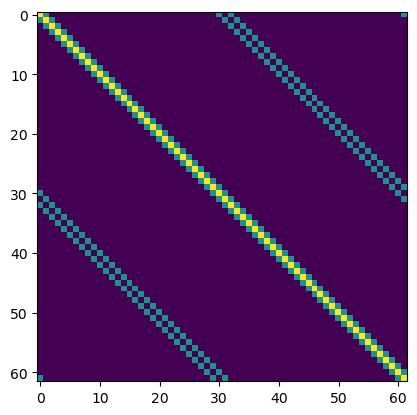

In [4]:
i = 0 ### selected value of theta
Nx = 31
Ny = 1
nbands = 30
nstates = 6

parameters = dict(
    Nx = Nx,
    Ny = Ny,
    kx = 0,
    ky = 0,
    mwilson = 1
)
kmin = -pi
kmax = pi

H = hamiltonian_wilson(parameters)
plt.imshow(np.abs(H.toarray()))

momenta, bands = make_bands_y_periodic(parameters,number_of_bands = nbands, number_of_points = int(501),kmin = kmin, kmax = kmax)

-0.5026548245743667


(-3.141592653589793, 3.141592653589793)

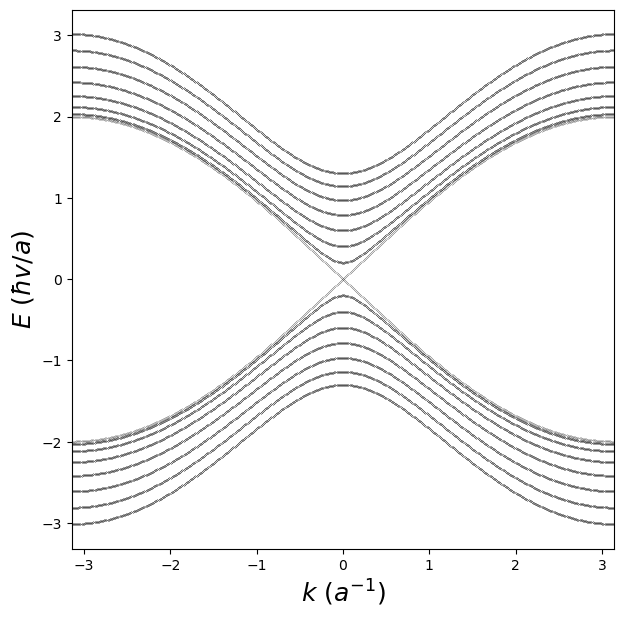

In [5]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
point = (np.abs(momenta + 0.5)).argmin()
print(momenta[point])

for i in range(nbands):
    ax.scatter(momenta, bands[:,i], c = 'k', s = 0.02)
#ax.axhline(0, c = 'k')
ax.set_ylabel(r"$E$ $(\hbar v/a)$",fontsize = 18)
ax.set_xlabel(r"$k$ $(a^{-1})$",fontsize = 18)
#ax.set_ylim(-1.1,1.1)
ax.set_xlim(kmin,kmax)

In [6]:
def cropped_Hamiltonian(parameters):
    H = hamiltonian_wilson(parameters)

    # Unitary transformation on the edges.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a theta,phi orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spindown,spinup] = np.sin(theta/2)*np.exp(1j*phi)
        rotation[spinup,spindown] = -np.sin(theta/2)*np.exp(-1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)
        
        return csc_matrix(rotation)
        
    # Now rotate the spins on the edge
    theta = parameters['theta']

    for y in range(Ny):
        rotation = spin_rotation([2,y], theta, 1*pi/2)
        H = rotation @ H @ (rotation.H)
        


    for y in range(Ny):
        #rotation = spin_rotation([Nx-3,y], theta, 1*pi/2)
        rotation = spin_rotation([Nx-3,y], pi-theta, 3*pi/2)
        H = rotation @ H @ (rotation.H)
        
    indices_to_delete = []#sites and spins on the edge. 


    def get_index(x,y,s):
        return int(Nx*Ny*s + Nx*y + x)
    
    for y in range(Ny):
        indices_to_delete.append(get_index(0,y,0)) #left edge
        indices_to_delete.append(get_index(0,y,1)) #left edge
        indices_to_delete.append(get_index(1,y,0)) #left edge
        indices_to_delete.append(get_index(1,y,1)) #left edge
        indices_to_delete.append(get_index(2,y,1)) #left edge
        
        indices_to_delete.append(get_index(Nx-1,y,0)) #right edge
        indices_to_delete.append(get_index(Nx-1,y,1)) #right edge
        indices_to_delete.append(get_index(Nx-2,y,0)) #right edge
        indices_to_delete.append(get_index(Nx-2,y,1)) #right edge
        indices_to_delete.append(get_index(Nx-3,y,1)) #right edge 
        
    # Transforming the sparse matrix into dense to delete spins
    H_aux = H.toarray()
    
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    H = csc_matrix(H_aux)
    
    # plt.imshow(np.abs(H.toarray()))
    # plt.show()
    
    return H, indices_to_delete

def make_bands_y(parameters,number_of_bands = int(20), number_of_points = int(101),kmin = -pi, kmax = pi):
 
    momenta = np.linspace(kmin,kmax, num = number_of_points)
    bands = np.zeros((number_of_points,number_of_bands))
    #Solve generalised eigenproblem fro all k
    for j, k in enumerate(momenta):
        parameters['ky'] = k
        H, deleted_indices = cropped_Hamiltonian(parameters)
        bands[j] = sla.eigsh(H, k = number_of_bands, tol = 1e-10, sigma = 1e-10, which = 'LM',return_eigenvectors = False)

    return momenta,bands

In [7]:
i = 100 ### selected value of theta
Nx = 35
Ny = 1
nbands = 22
nstates = 6

parameters = dict(
    Nx = Nx,
    Ny = Ny,
    theta = (pi/2)*(i/100),
    kx = 0,
    ky = 0,
    mwilson = 1
)
kmin = -pi
kmax = pi

momenta, bands = make_bands_y(parameters,number_of_bands = nbands, number_of_points = int(201),kmin = kmin, kmax = kmax)

0.9995065603657335
-0.9995065603657319
1.4444965936097667
-1.4444965936097616
1.4687889135156325
-1.4687889135156336


(-3.141592653589793, 3.141592653589793)

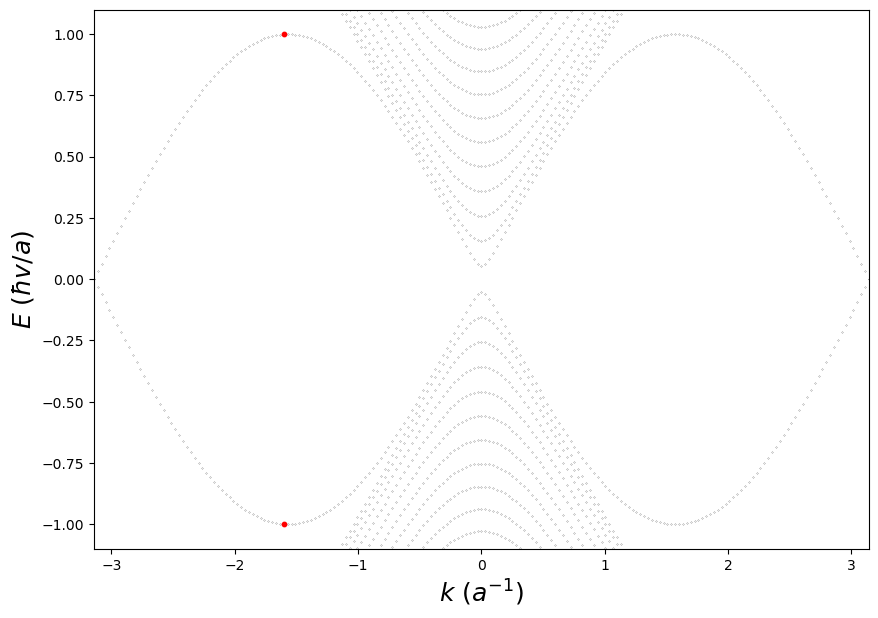

In [8]:
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111)
point = (np.abs(momenta + 50/(Nx-4))).argmin()
#print(momenta[point])

for i in range(nbands):
    ax.scatter(momenta, bands[:,i], c = 'k', s = 0.02)
for j in range(nstates):
    ax.scatter(momenta[point], bands[point,nbands-1-j], c = 'r', s = 10)
    print(bands[point,nbands-1-j])
#ax.axhline(0, c = 'k')
ax.set_ylabel(r"$E$ $(\hbar v/a)$",fontsize = 18)
ax.set_xlabel(r"$k$ $(a^{-1})$",fontsize = 18)
ax.set_ylim(-1.1,1.1)
ax.set_xlim(kmin,kmax)

In [9]:
def plot_states(parameters,number_of_bands = 6):
    H, deleted_indices = cropped_Hamiltonian(parameters)
    eigenvalues, eigenvectors = sla.eigsh(H, k = number_of_bands, tol = 0, sigma = 0, which = 'LM',return_eigenvectors = True)

    #Refill with zeros the deleted spins

    states = np.zeros((2*Nx*Ny,number_of_bands),dtype = complex)
    count = 0
    for index in range(2*Nx*Ny):
        if index not in deleted_indices:
            states[index] = (eigenvectors)[index-count]
        else:
            count += 1

    # Unitary transformation on the edges.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a theta,phi orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spindown,spinup] = np.sin(theta/2)*np.exp(1j*phi)
        rotation[spinup,spindown] = -np.sin(theta/2)*np.exp(-1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)
        
        return csc_matrix(rotation)
        
    # Now rotate the spins on the edge
    theta = parameters['theta']

    for y in range(Ny):
        rotation = spin_rotation([2,y], theta, 1*pi/2)
        states = (rotation.H)@states

    for y in range(Ny):
        #rotation = spin_rotation([Nx-3,y], theta, 1*pi/2)
        rotation = spin_rotation([Nx-3,y], pi-theta, 3*pi/2)
        states = (rotation.H)@states

        
    # # The following five lines are necessary only if we expect to get two zero modes!!!!
    # chirality = scipy.sparse.kron(csc_matrix(sigma_z), np.identity(Nx*Ny), format = "csc")
    # save0 = (states[:,0]+chirality@states[:,0])/np.sqrt(2)
    # save1 = (states[:,0]-chirality@states[:,0])/np.sqrt(2)
    # states[:,0] = save0
    # states[:,1] = save1

    norm = np.sqrt(np.diag(np.abs(states.conjugate().transpose()@states)))
    states = states/norm[None,:]   
    
    ###Now order and reshape
    order = np.argsort(np.abs(eigenvalues))
    states = np.reshape(states[:,order].flatten('F'), newshape = (number_of_bands,2,Ny,Nx), order = 'C')      
    energies = eigenvalues[order]
    
    #PLOT
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    axs = axs.flatten()

    for i in range(number_of_bands):
        probability_density  = np.sum(np.abs((states[i]))**2,axis = 0)
        spin_up_density  = np.abs((states[i,0]))**2
        spin_down_density  = np.abs((states[i,1]))**2    
        
        
        axs[i].plot(np.arange(Nx-4),  spin_up_density[0,2:-2], c = "C0")
        axs[i].scatter(np.arange(Nx-4),  spin_up_density[0,2:-2], c = "C0")
        axs[i].plot(np.arange(Nx-4),  spin_down_density[0,2:-2], c = "C1")
        axs[i].scatter(np.arange(Nx-4),  spin_down_density[0,2:-2], c = "C1")
        axs[i].set_ylabel(r"$|\psi_\sigma|^2$",fontsize = 12)
        axs[i].set_xlabel(r"$y$ $(a)$",fontsize = 12)
       
        formatted_number = f"{energies[i]:.4e}"
        axs[i].text(0.65, 0.8, "E= "+str(formatted_number), transform=axs[i].transAxes,
                fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

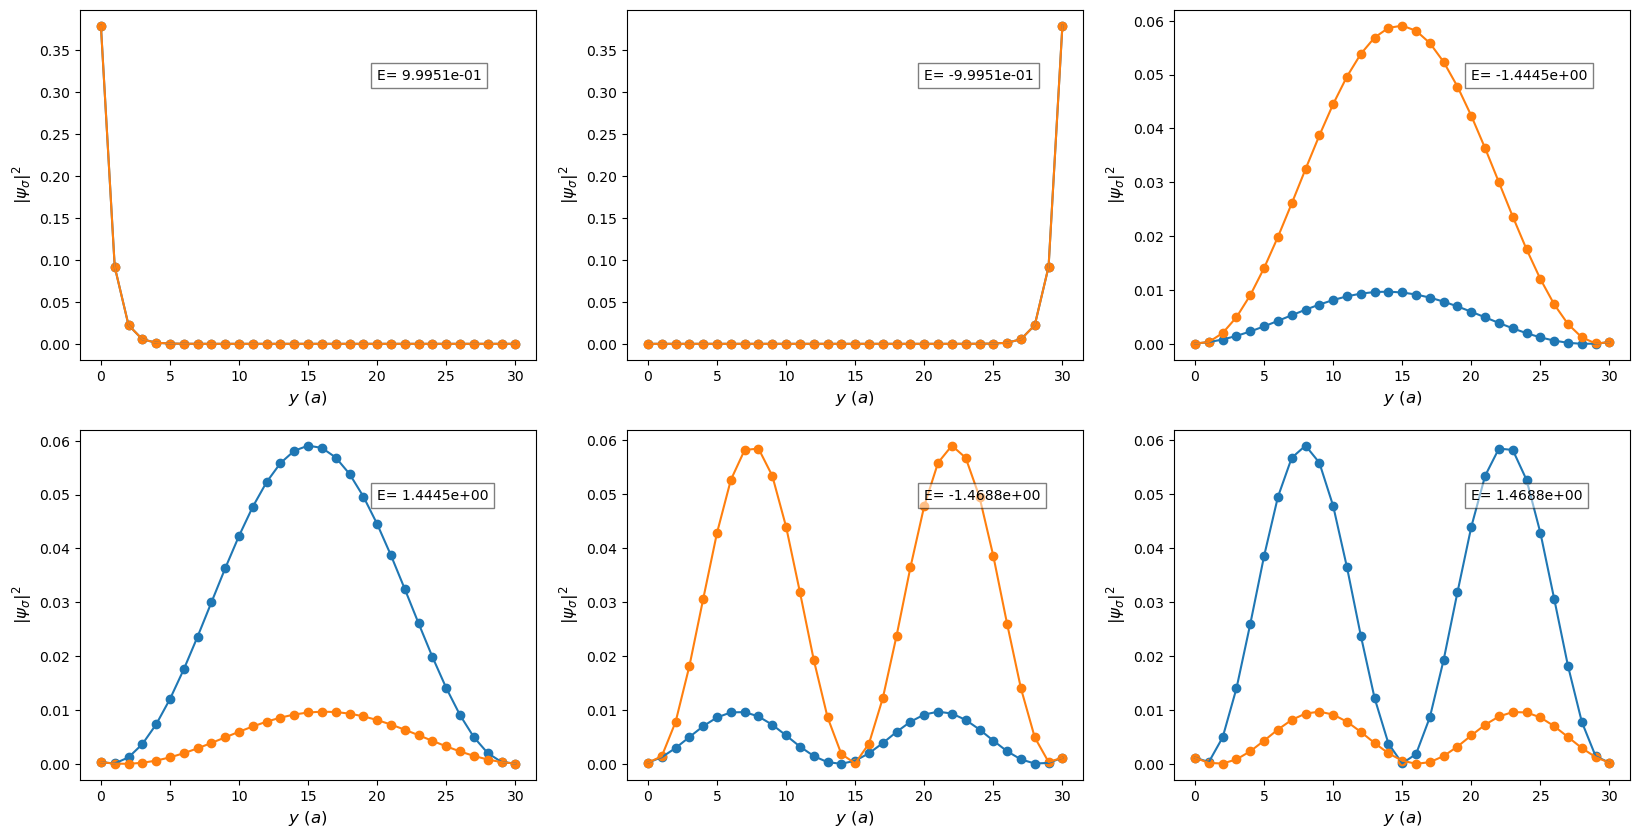

In [10]:
parameters['ky'] = momenta[point]

plot_states(parameters, number_of_bands=nstates)

In [11]:
def plot_states_paper(parameters,number_of_bands = 6, state_to_plot = 0):
    H, deleted_indices = cropped_Hamiltonian(parameters)
    eigenvalues, eigenvectors = sla.eigsh(H, k = number_of_bands, tol = 0, sigma = 0, which = 'LM',return_eigenvectors = True)

    #Refill with zeros the deleted spins

    states = np.zeros((2*Nx*Ny,number_of_bands),dtype = complex)
    count = 0
    for index in range(2*Nx*Ny):
        if index not in deleted_indices:
            states[index] = (eigenvectors)[index-count]
        else:
            count += 1

    # Unitary transformation on the edges.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a theta,phi orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spindown,spinup] = np.sin(theta/2)*np.exp(1j*phi)
        rotation[spinup,spindown] = -np.sin(theta/2)*np.exp(-1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)
        
        return csc_matrix(rotation)
        
    # Now rotate the spins on the edge
    theta = parameters['theta']

    for y in range(Ny):
        rotation = spin_rotation([2,y], theta, 1*pi/2)
        states = (rotation.H)@states

    for y in range(Ny):
        rotation = spin_rotation([Nx-3,y], theta, 1*pi/2)
        #rotation = spin_rotation([Nx-3,y], pi-theta, 3*pi/2)
        states = (rotation.H)@states

        
    # # The following five lines are necessary only if we expect to get two zero modes!!!!
    # chirality = scipy.sparse.kron(csc_matrix(sigma_z), np.identity(Nx*Ny), format = "csc")
    # save0 = (states[:,0]+chirality@states[:,0])/np.sqrt(2)
    # save1 = (states[:,0]-chirality@states[:,0])/np.sqrt(2)
    # states[:,0] = save0
    # states[:,1] = save1

    norm = np.sqrt(np.diag(np.abs(states.conjugate().transpose()@states)))
    states = states/norm[None,:]   
    
    ###Now order and reshape
    order = np.argsort(np.abs(eigenvalues))
    states = np.reshape(states[:,order].flatten('F'), newshape = (number_of_bands,2,Ny,Nx), order = 'C')      
    energies = eigenvalues[order]
    
     #PLOT
    fig, axs = plt.subplots(1, 1, figsize=(7, 7))

    i = state_to_plot
    probability_density  = np.sum(np.abs((states[i]))**2,axis = 0)
    spin_up_density  = np.abs((states[i,0]))**2
    spin_down_density  = np.abs((states[i,1]))**2    
    
    
    axs.plot(np.arange(Nx-4),  spin_up_density[0,2:-2], c = "C0")
    axs.scatter(np.arange(Nx-4),  spin_up_density[0,2:-2], c = "C0")
    axs.plot(np.arange(Nx-4),  spin_down_density[0,2:-2], c = "C1")
    axs.scatter(np.arange(Nx-4),  spin_down_density[0,2:-2], c = "C1")
    axs.set_ylabel(r"$|\psi_\sigma|^2$",fontsize = 12)
    axs.set_xlabel(r"$y$ $(a)$",fontsize = 12)

    y = np.arange(Nx-4)
    kappa = (2-np.cos(parameters['ky'])-1)
    fy = spin_up_density[0,2]*np.exp(-kappa*y)

    axs.plot(y,fy, c = 'k', ls ='--')
   
    formatted_number = f"{energies[i]:.4e}"
    axs.text(0.5, 0.5, "E= "+str(formatted_number), transform=axs.transAxes,
            fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

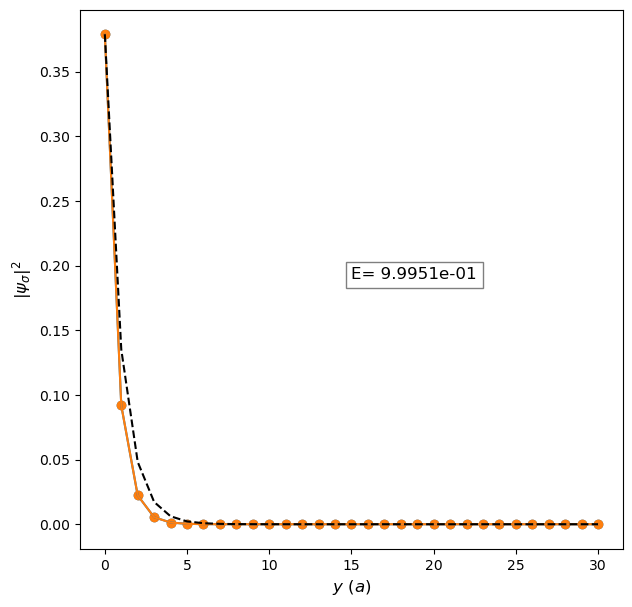

In [12]:
plot_states_paper(parameters, number_of_bands=nstates, state_to_plot = 0)

In [13]:
y = np.arange(Nx-4)
kappa = (2-np.cos(parameters['ky'])-1)
fy = 0.09*np.exp(-kappa*y)

1.3347153050225388e-14
-1.2556518020860797e-14
-2.008478206046331
2.0084782070408775
-2.0335875283206106
2.033587531103166


(-3.141592653589793, 3.141592653589793)

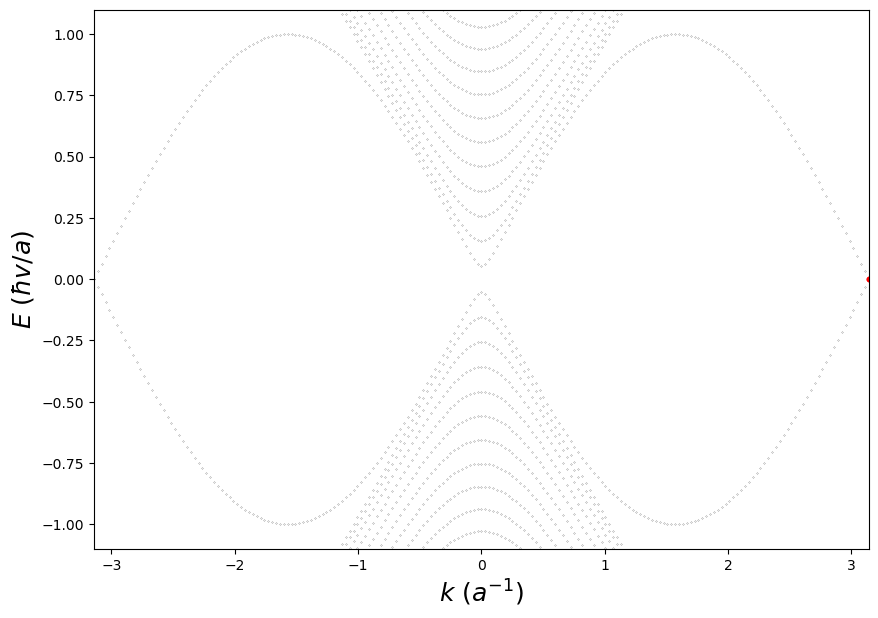

In [14]:
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111)
point = (np.abs(momenta - pi)).argmin()
#print(momenta[point])

for i in range(nbands):
    ax.scatter(momenta, bands[:,i], c = 'k', s = 0.02)
for j in range(nstates):
    ax.scatter(momenta[point], bands[point,nbands-1-j], c = 'r', s = 10)
    print(bands[point,nbands-1-j])
#ax.axhline(0, c = 'k')
ax.set_ylabel(r"$E$ $(\hbar v/a)$",fontsize = 18)
ax.set_xlabel(r"$k$ $(a^{-1})$",fontsize = 18)
ax.set_ylim(-1.1,1.1)
ax.set_xlim(kmin,kmax)

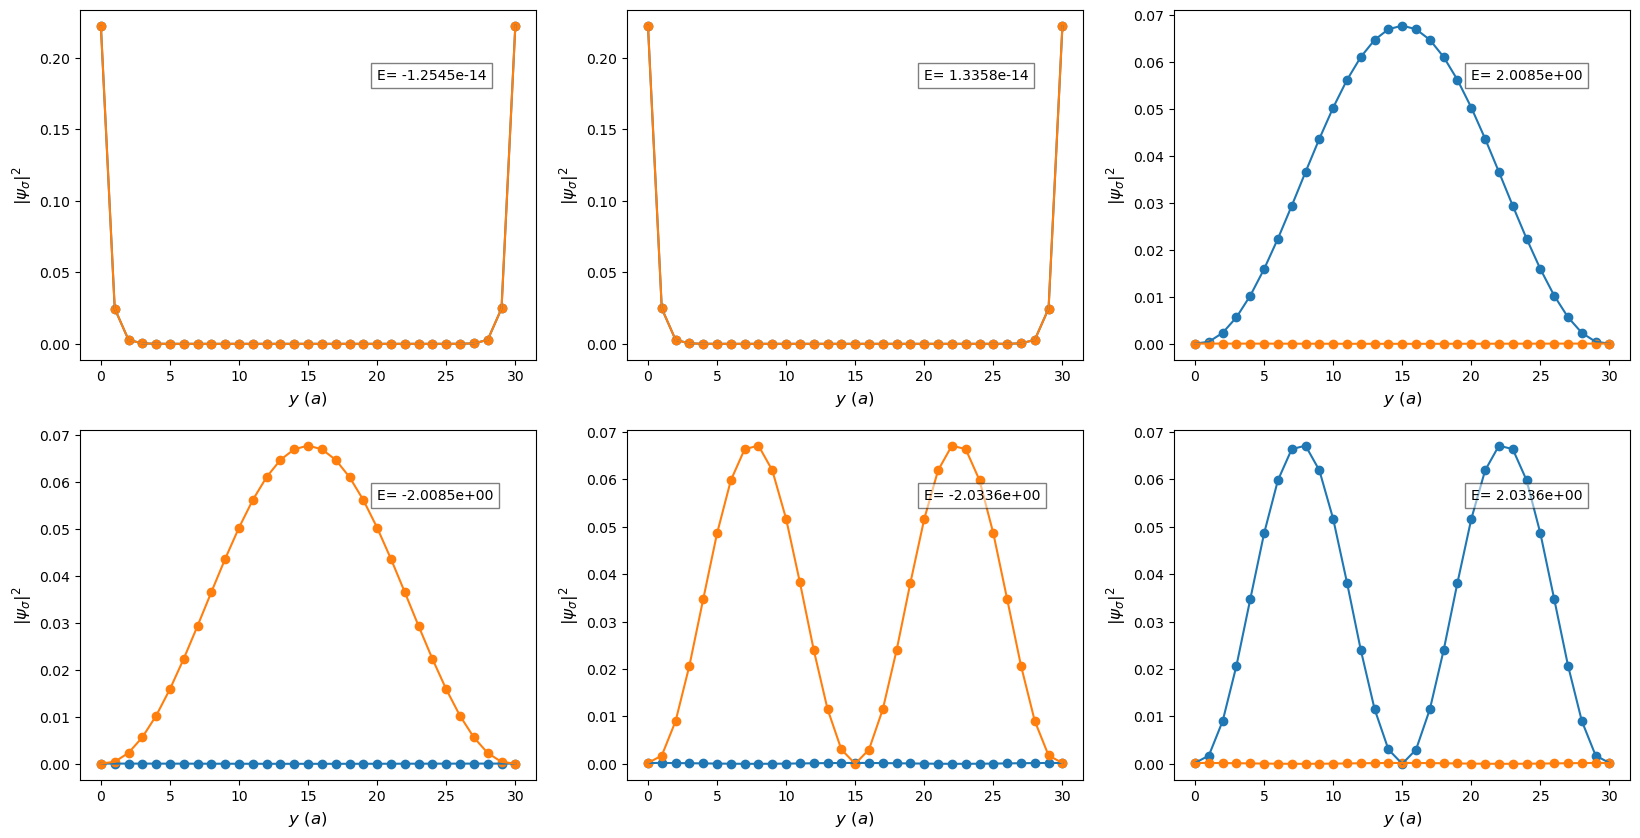

In [15]:
parameters['ky'] = momenta[point]

plot_states(parameters, number_of_bands=nstates)